# Multi Ageent Reinforcement Learning---- Basic Methods

Methods:
- (1) Joint Q Learning
- (2) Independent Q Learning
- (3) Minmax-Q

Your works:
- (1) Make an overview of the notebook
- (2) Implmenting the Minmax-Q Method
- (3) Make an analysis about these methods (non-stationarity, astringency)

Package requirements:
- (1) numpy
- (2) matplotlib
- (3) scipy
- (4) gym

Tips:
In the answer I have fixed the bug of learning rate.

## Task
![avatar](/env/map.png)

We build a simple mini-grid task, the target is let the two agent (blue and red) meet each other. The setting of the tasks is following:
- State: The local state is the coordination of each agent. And the global state is the concatenate coordination of both agents.
- Action: The action space in our environment contains four actions $\{east, south, west, north\}$, each action is the moving direction of the agent.
- Reward: The external reward in our experiment is the Manhattan distance of the two agents.

## Joint Q Learning (Centralized joint policy learning)

The simplest MARL method is directly using single agent methods like Q-learning. 
The only change is using the joint action and joint observation to replace the action and state in single agent setting.
(Generally, other agent's policy will be fixed when executing one agent)

#### Recap: Q-Learning
- Maximize the $Q$ function $Q(s,a)$
- $Q(s,a) \longleftarrow (1-\alpha)Q(s,a) + \alpha(r+\gamma V'(s'))$
- $V'(s') = \min \limits_{a'}Q(s',a')$

### Procedure of Joint Q Learning

- The agents choose actions according to their policies.
- For agent $j$, the corresponding policy is defined as $\pi_j:S \longrightarrow \omega(A^j)$, where $\omega(A^j)$ is the 
    collection of probability distributions over agent $j$’s action space $A_j$.
- Let $\boldsymbol{\pi}=[\pi^1,...\pi^n]$ is the joint policy of all agents, then
$$V_{\pi}^j(s)=\sum_{t=0}\gamma^t\mathbb{E}_{\boldsymbol{\pi},p}[r^j_t]$$
- Q-function $Q^j_{\pi}:S\times A^1\times ... \times A^n \longrightarrow \mathbb{R}$ of agent j under the joint policy $\boldsymbol{\pi}$:
 $$Q^j_{\pi}(s, \boldsymbol{a})=r^j(s, \boldsymbol{a})+\gamma \mathbb{E}_{s'}[V_{\pi}^j(s')]$$
 where $\boldsymbol{a}=\{a_0,a_1,...a_n\}$

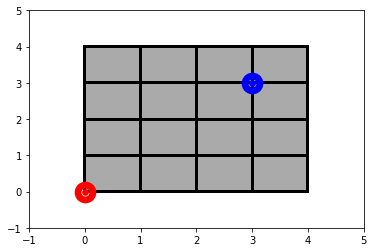

In [2]:
import numpy as np
import random
from env import TestEnv
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
# from jupyterplot import ProgressPlot

In [3]:
class JointQLearner(object):
    def __init__(self):
        # q_table (A joint q_table)
        self.q_table = np.zeros((4, 4, 4, 4, 16))
        # learning rate
        self.lr = 0.5
        # discount
        self.gamma = 0.9
        # exploration rate
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        self.env = TestEnv()

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            q_action_value = self.q_table[state[0], state[1], state[2], state[3]]
            action = np.argmax(q_action_value)
        else:
            action = random.randint(0, 15)
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        self.q_table[state[0], state[1], state[2], state[3], action] = \
            (1- self.lr) * self.q_table[state[0], state[1], state[2], state[3], action] + self.lr * \
            (reward + self.gamma * np.max(self.q_table[next_state[0], next_state[1], next_state[2], next_state[3]]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}". format(epsoide, long_term_reward))
                    # print(np.min(self.q_table))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

    def save_q_value_matrix(self):
        np.save("./optimal_q_value.npy", self.q_table)

    def load_q_value_matrix(self):
        self.q_table = np.load("./optimal_q_value.npy")

In [4]:
learner = JointQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -63
Epsoide: 100  Expected Reward: -121
Epsoide: 200  Expected Reward: -6
Epsoide: 300  Expected Reward: -6
Epsoide: 400  Expected Reward: -8
Epsoide: 500  Expected Reward: -6


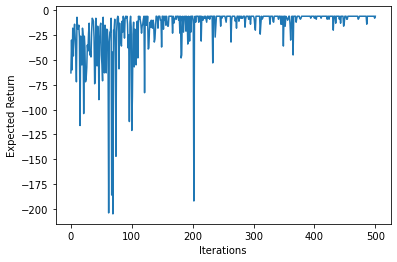

In [5]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

## Independent Q-learning

In independent Q-learning, each agent $i$ has its own Q function and treats other agents as a part of the environment.


### Procedure of Independent Q Learning
- Each agent $i$ have a individual $Q$ function $Q(s_i,a_i)$;
- For each agent's $Q$ function, it is updated by:

    $Q(s_i,a_i) \longleftarrow (1-\alpha)Q(s_i,a_i) + \alpha(r+\gamma V'({s_i}'))$
- $V'({s_i}') = \max \limits_{{a_i}'}Q({s_i}',{a_i}')$

The main shortage is \textbf{non-stationarity} and hard to learn cooperation.

In [6]:
class IndependentQLearner(object):
    def __init__(self):
        # q_table (Each agent has their own q_table)
        self.q_table_alpha = np.zeros((4, 4, 4, 4, 4))
        self.q_table_beta = np.zeros((4, 4, 4, 4, 4))
        # learning rate
        self.lr = 0.5
        # discount
        self.gamma = 0.9
        # exploration rate
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        # build environment
        self.env = TestEnv(joint=False, share_obs=True)

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            q_action_value_alpha = self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3]]
            q_action_value_beta = self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3]]
            action_alpha = np.argmax(q_action_value_alpha)
            action_beta = np.argmax(q_action_value_beta)
            action = action_alpha * 4 + action_beta
        else:
            action = random.randint(0, 15)
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        act_a, act_b = divmod(action, 4)
        self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_a] = \
            (1- self.lr) * self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_a] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_alpha[next_state[0][0], next_state[0][1],
                                                             next_state[0][2], next_state[0][3]]))

        self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], act_b] = \
            (1- self.lr) * self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], act_b] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_beta[next_state[1][0], next_state[1][1],
                                                            next_state[1][2], next_state[1][3]]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}". format(epsoide, long_term_reward))
                    # print(np.min(self.q_table))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

In [7]:
learner = IndependentQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -29
Epsoide: 100  Expected Reward: -18
Epsoide: 200  Expected Reward: -10
Epsoide: 300  Expected Reward: -6
Epsoide: 400  Expected Reward: -6
Epsoide: 500  Expected Reward: -6


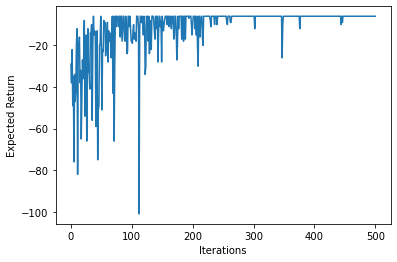

In [8]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

## Minmax-Q

Like independent Q learning, each agent $i$ has its own Q function

Q-values are over joint actions: $Q(s,a,o)$:
- $s = \text{action}$
- $a = \text{your action}$
- $o = \text{action of the opponent}$
Instead of playing action with highest $Q(s, a, o)$, play \textbf{MinMax}
$$ Q(s,a,o) = (1-\alpha)Q(s,a,o)+\alpha(r+\gamma V(s'))$$
$$ V(s') = \max\limits_{\pi(s')}\min\limits_{o'}\sum_a Q(s',a',o')$$

Minmax-Q can deal with non-stationarity. It has been proven that the method can reach the $\text{Nash equilibrium}$

## Procedure of Minmax-Q

![avatar](/env/minmax-q.jpg)

In [9]:
class MinmaxQLearner(object):
    def __init__(self):
        # Here you also need to consider about the other agent' action
        self.q_table_alpha = np.zeros((4, 4, 4, 4, 4, 4))
        self.q_table_beta = np.zeros((4, 4, 4, 4, 4, 4))
        self.lr = 0.5
        self.gamma = 0.9
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        self.env = TestEnv(joint=False, share_obs=True)

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            # Here you need to implment the action choice in Minmax-Q
            # You can refer to the implmentation of independent Q learning
            # Tips: In Minmax-Q learning, you must consider about the other agent's action
            ####

            # Please implment the choose action procedure here
            
            # get the average q_value when opponent use different actions
            alpha_opponent_q_value = \
                [np.mean(self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], b])
                 for b in range(4)]
            beta_opponent_q_value = \
                [np.mean(self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], a])
                 for a in range(4)]
            
            # The min process, get the opponent's action which will make the agent's q value worest
            alpha_opponent_action = np.argmin(alpha_opponent_q_value)
            beta_opponent_action = np.argmin(beta_opponent_q_value)
            q_action_value_alpha = self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3],
                                                      alpha_opponent_action]
            q_action_value_beta = self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3],
                                                    beta_opponent_action]
            action_alpha = np.argmax(q_action_value_alpha)
            action_beta = np.argmax(q_action_value_beta)
            ####
            action = action_alpha * 4 + action_beta
        else:
            action = random.randint(0, 15)
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        act_a, act_b = divmod(action, 4)

        ####

        # Please implment the optimazation procedure here
        # self.q_table_alpha = ...
        # self.q_table_beta = ...
        ####
        
        # get the average next q_value when opponent use different actions
        alpha_opponent_q_value = \
            [np.mean(self.q_table_alpha[next_state[0][0], next_state[0][1], next_state[0][2], next_state[0][3], b])
             for b in range(4)]
        beta_opponent_q_value = \
            [np.mean(self.q_table_beta[next_state[1][0], next_state[1][1], next_state[1][2], next_state[1][3], a])
             for a in range(4)]
        
        # The min process, get the opponent's action which will make the agent's q value worest
        alpha_opponent_action = np.argmin(alpha_opponent_q_value)
        beta_opponent_action = np.argmin(beta_opponent_q_value)
        
        # max process
        self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_b, act_a] = \
            (1 - self.lr) * self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_b, act_a] + \
            self.lr * (reward + self.gamma * np.max(self.q_table_alpha[next_state[0][0], next_state[0][1],
                                                                       next_state[0][2], next_state[0][3],
                                                                       alpha_opponent_action]))
        
        self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], act_a, act_b] = \
            (1 - self.lr) * self.q_table_beta[
                state[1][0], state[1][1], state[1][2], state[1][3], act_a, act_b] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_beta[next_state[1][0], next_state[1][1],
                                                            next_state[1][2], next_state[1][3],
                                                            beta_opponent_action]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}".format(epsoide, long_term_reward))
                    # print(np.min(self.q_table))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

In [10]:
learner = MinmaxQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -24
Epsoide: 100  Expected Reward: -9
Epsoide: 200  Expected Reward: -8
Epsoide: 300  Expected Reward: -6
Epsoide: 400  Expected Reward: -6
Epsoide: 500  Expected Reward: -6


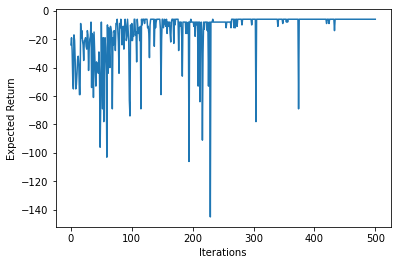

In [11]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

What will happen if we use the max max?(change the argmin to argmax)

In [12]:
class MaxmaxQLearner(object):
    def __init__(self):
        # Here you also need to consider about the other agent' action
        self.q_table_alpha = np.zeros((4, 4, 4, 4, 4, 4))
        self.q_table_beta = np.zeros((4, 4, 4, 4, 4, 4))
        self.lr = 0.5
        self.gamma = 0.9
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        self.env = TestEnv(joint=False, share_obs=True)

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            # Here you need to implment the action choice in Minmax-Q
            # You can refer to the implmentation of independent Q learning
            # Tips: In Minmax-Q learning, you must consider about the other agent's action
            ####

            # Please implment the choose action procedure here
            alpha_opponent_q_value = \
                [np.mean(self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], b])
                 for b in range(4)]
            beta_opponent_q_value = \
                [np.mean(self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], a])
                 for a in range(4)]
            alpha_opponent_action = np.argmax(alpha_opponent_q_value)
            beta_opponent_action = np.argmax(beta_opponent_q_value)
            q_action_value_alpha = self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3],
                                                      alpha_opponent_action]
            q_action_value_beta = self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3],
                                                    beta_opponent_action]
            action_alpha = np.argmax(q_action_value_alpha)
            action_beta = np.argmax(q_action_value_beta)
            ####
            action = action_alpha * 4 + action_beta
        else:
            action = random.randint(0, 15)
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        act_a, act_b = divmod(action, 4)

        ####

        # Please implment the optimazation procedure here
        # self.q_table_alpha = ...
        # self.q_table_beta = ...
        ####
        alpha_opponent_q_value = \
            [np.mean(self.q_table_alpha[next_state[0][0], next_state[0][1], next_state[0][2], next_state[0][3], b])
             for b in range(4)]
        beta_opponent_q_value = \
            [np.mean(self.q_table_beta[next_state[1][0], next_state[1][1], next_state[1][2], next_state[1][3], a])
             for a in range(4)]
        alpha_opponent_action = np.argmax(alpha_opponent_q_value)
        beta_opponent_action = np.argmax(beta_opponent_q_value)
        self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_b, act_a] = \
            (1 - self.lr) * self.q_table_alpha[state[0][0], state[0][1], state[0][2], state[0][3], act_b, act_a] + \
            self.lr * (reward + self.gamma * np.max(self.q_table_alpha[next_state[0][0], next_state[0][1],
                                                                       next_state[0][2], next_state[0][3],
                                                                       alpha_opponent_action]))

        self.q_table_beta[state[1][0], state[1][1], state[1][2], state[1][3], act_a, act_b] = \
            (1 - self.lr) * self.q_table_beta[
                state[1][0], state[1][1], state[1][2], state[1][3], act_a, act_b] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_beta[next_state[1][0], next_state[1][1],
                                                            next_state[1][2], next_state[1][3],
                                                            beta_opponent_action]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}".format(epsoide, long_term_reward))
                    # print(np.min(self.q_table))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

In [13]:
learner = MaxmaxQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -36
Epsoide: 100  Expected Reward: -19
Epsoide: 200  Expected Reward: -109
Epsoide: 300  Expected Reward: -11
Epsoide: 400  Expected Reward: -26
Epsoide: 500  Expected Reward: -11


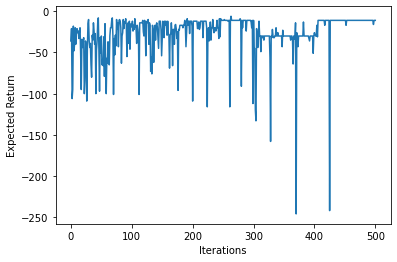

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)